In [8]:
import sys
from typing import Tuple, List

import networkx as nx

sys.path.append("/tmp/pycharm_project")

from scheme.cells import *
from scheme.util import StatefulPRNGKey, _randomized_proportions, exponential, negative_binomial, jax_jit, consumes_key, \
    jax_vmap, generalized_logistic
from scheme.simulations import _generate_gene_networks
from scheme.plotting import _draw_voronoi_slice, _draw_voronoi_slices_animation
from scheme.voronoi import jump_flooding

import pandas as pd
import jax.numpy as jnp
import numpy as np
from plotnine import *
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

#!pip install liana

# Random Seed
seed = 1234567890

key = StatefulPRNGKey(seed)

In [9]:
# Number of cells to generate
n_cells = 2500
# Number of "cell types" to generate
n_celltypes = 4
# The proportion of cells that die per timestep
p_death = 0.05
# The proportion of cells that move per timestep
p_move = 0.05
# Max count of expression by random expectation
max_expression = 100
# Probability of a gene being expressed
p_expression = 0.75

# Toy Gene Network Parameters
# Number of genes to generate
n_genes = 250
# The probability of a "mutation" event occuring when generating gene interaction networks. (adding or removing edges when "duplicating")
p_network_mutation = 0.4
# Probability of a gene transitioning into a receptor
p_receptor = 0.05

In [10]:
# Generate a toy gene network
lr_pairs, base_gene_backbone, gene_backbones = _generate_gene_networks(n_genes, n_celltypes, key)

<AxesSubplot: >

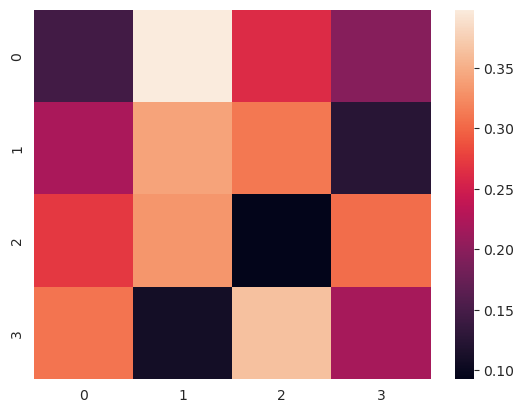

In [11]:
#cell_type_interaction_probs = jnp.array([_randomized_proportions(n_celltypes, prioritize_group=None, rng_key=key).tolist() for i in range(n_celltypes)])

# Heatmap of interaction probabilities
#sns.heatmap(cell_type_interaction_probs)

/opt/conda/envs/scheme_env/lib/python3.9/site-packages/jax/_src/numpy/reductions.py:205: UserWarning: Explicitly requested dtype <class 'numpy.integer'> requested in sum is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


<Figure size 640x480 with 0 Axes>

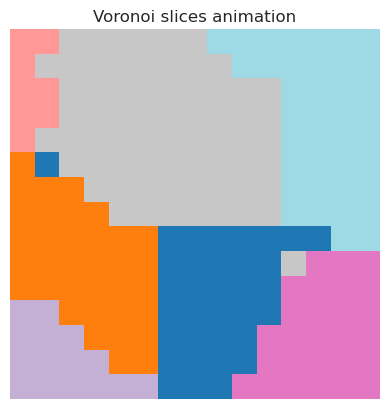

In [12]:
import jax  # 3D matrix, so we need to take the 3rd root of n_cells
max_seeds_per_cell = 10  # Number of initial tesselations given for each cell type, higher numbers leads to greater heterogeneity
jump_flooding_p = jnp.inf  # Hyperparameter for determining the minkowski distance used in jump flooding (p=1 is Manhattan distance, p=2 is Euclidean distance, p=inf is Chebyshev distance)
# This can effect the shape of the individual tiles created
matrix_dimension = int(n_cells**(1/3))

    # Number of voronoi seeds per cell type
    n_seeds = jax.random.randint(key(), (n_celltypes,), minval=1, maxval=max_seeds_per_cell)
    # Make an indexing array to determine cell types -> voronoi seeds
    celltypes2index = jnp.cumsum(n_seeds)

    # Perform the tesselation
    voronoi = jump_flooding(matrix_dimension, jnp.sum(n_seeds, dtype=jnp.integer).item(), key, p=jump_flooding_p)

HTML(_draw_voronoi_slices_animation(voronoi, title="Voronoi slices animation").to_jshtml())

<Figure size 640x480 with 0 Axes>

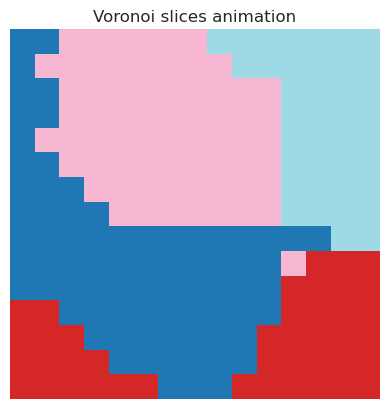

In [13]:
# Overwrite seed numbers with corresponding cell type
for celltype, max_index in enumerate(celltypes2index):
    last_max_index = 0 if celltype == 0 else celltypes2index[celltype - 1]
    voronoi = jnp.where((voronoi >= last_max_index) & (voronoi < max_index), celltype, voronoi)

HTML(_draw_voronoi_slices_animation(voronoi, title="Voronoi slices animation").to_jshtml())

In [ ]:
# Generate parameters for simulations
# Mask for cell types
cell_type_mask = jnp.array([jnp.where(voronoi == celltype, 1, 0) for celltype in range(n_celltypes)])
# Select ligand indices
ligand_indices = jnp.array(set(l for l, r in lr_pairs), dtype=jnp.integer).item()
# Modulates the emission strength of ligands
ligand_emission_propensities = jax.random.uniform(key(), ligand_indices.shape)

# Cell type mobility propensities, represents the mean for a poisson distribution to select distance to move
cell_type_mobility_range = exponential(1, (n_celltypes,), key)
# Cell type mobility propensities, used for selecting cells to move
cell_type_mobility_propensities = jax.random.uniform(key(), (n_celltypes,))

# Initialize expression matrix
expression = negative_binomial(max_expression, p_expression, (n_cells, n_genes), key)

In [ ]:
@jax_vmap(in_axes=(0, None, None))  # For each index
@jax_jit(static_argnums=(2,))
def cell_index_to_position(index: int, shape: tuple) -> tuple:
    return jnp.unravel_index(index, shape)


@jax_vmap(in_axes=(0, None, None))  # For each position
@jax_jit(static_argnums=(2,))
def position_to_cell_index(position: tuple, shape: tuple) -> int:
    return jnp.ravel_multi_index(position, shape).item()


@consumes_key(2, 'key')
@jax_jit()
def select_neighbors(voronoi_map: jnp.array, positions: jnp.array, key: StatefulPRNGKey) -> jnp.array:
    # Determine all possible 3d offsets
    offsets = jnp.meshgrid(jnp.arange(-1, 2), jnp.arange(-1, 2), jnp.arange(-1, 2))
    # Choose the 3d offsets
    selected_offsets = jax.random.randint(key, (positions.shape[0],), 0, offsets.shape[0])
    # Map the selected offset indices to the true offsets
    selected_offsets = offsets[selected_offsets]
    # add offsets to positions and clip to voronoi map shape
    return jnp.clip((positions + selected_offsets), 0, voronoi_map.shape[0]-1)


@consumes_key(3, 'key', count=2)
@jax_jit()
def death_replication_step(voronoi_map: jnp.array, expression_matrix: jnp.array, p_death: float, key: StatefulPRNGKey) -> Tuple[jnp.array, jnp.array]:
    # Select cells to die
    death_mask = jax.random.bernoulli(key[0], p_death, voronoi_map.shape)
    # Get the coordinates of the cells to die
    death_positions = jnp.argwhere(death_mask)
    # Select cells that can replicate to fill in the death mask
    to_replicate = select_neighbors(voronoi_map, death_positions, key[1])
    # Replace the cells that died with the cells that can replicate
    voronoi_map = voronoi_map.at[death_positions[:, 0], death_positions[:, 1], death_positions[:, 2]].set(voronoi_map[to_replicate[:, 0], to_replicate[:, 1], to_replicate[:, 2]])

    # Convert positions to rows in the expression matrix
    death_rows = position_to_cell_index(death_positions, voronoi_map.shape)
    to_replicate_rows = position_to_cell_index(to_replicate, voronoi_map.shape)
    expression_matrix = expression_matrix.at[death_rows, :].set(expression_matrix[to_replicate_rows, :])

    return voronoi_map, expression_matrix


@jax_jit()
def swap_elements(array: jnp.array, index1, index2) -> jnp.array:
    temp = array[index1]
    array = array.at[index1].set(array[index2])
    array = array.at[index2].set(temp)
    return array


@jax_jit()
def swap_rows(array: jnp.array, row1, row2) -> jnp.array:
    temp = array[row1, :]
    array = array.at[row1, :].set(array[row2, :])
    array = array.at[row2, :].set(temp)
    return array


@jax_jit()
def _move_cell_iteration(voronoi_map: jnp.array, expression_matrix: jnp.array, movement_distance_3d: jnp.array, movement_list: jnp.array, movement_list_offset: int):
    # Get first cell position to move
    cell_position = jnp.argwhere(movement_distance_3d > 0)[0]
    remaining_distance = movement_distance_3d[cell_position[0], cell_position[1], cell_position[2]]
    # Update the distance
    movement_distance_3d = movement_distance_3d.at[cell_position[0], cell_position[1], cell_position[2]].set(remaining_distance - 1)
    # Get the movement
    movement = movement_list[movement_list_offset]
    # Update the movement list offset
    movement_list_offset += 1
    # Get the destination position
    destination_position = cell_position + movement
    # Clip to range
    destination_position = jnp.clip(destination_position, 0, voronoi_map.shape[0]-1)
    # Swap cell positions in 3d space
    voronoi_map = swap_elements(voronoi_map, cell_position, destination_position)
    movement_distance_3d = swap_elements(movement_distance_3d, cell_position, destination_position)
    # Get 1-d index of cell position
    cell_index = position_to_cell_index(cell_position, voronoi_map.shape)
    # Get 1-d index of destination position
    destination_index = position_to_cell_index(destination_position, voronoi_map.shape)
    # Swap cell positions in expression matrix
    expression_matrix = swap_rows(expression_matrix, cell_index, destination_index)

    return voronoi_map, expression_matrix, movement_distance_3d, movement_list, movement_list_offset


@consumes_key(5, 'key', count=3)
@jax_jit()
def cell_movement_step(voronoi_map: jnp.array, expression_matrix: jnp.array, cell_type_mask: jnp.array, cell_type_mobility_propensities: jnp.array, p_move: float, key: StatefulPRNGKey) -> Tuple[jnp.array, jnp.array]:
    # Label cells by propensity to move
    celltypes = cell_type_mask.shape[0]
    # For each cell type, select the celltype mask
    movement_propensities = jax.lax.fori_loop(0, celltypes, lambda i, x: (x + jnp.full(voronoi_map.shape, cell_type_mobility_propensities[i])), jnp.zeros_like(voronoi_map))
    # Normalize the movement propensities to be independent probabilities
    movement_propensities = movement_propensities / jnp.sum(movement_propensities)
    # Then multiply by the probability of moving
    movement_propensities = movement_propensities * p_move
    # Select cells to move by using propensities as a bernoulli mask
    movement_mask = jax.random.bernoulli(key[0], movement_propensities)
    # Get the coordinates of the cells to move
    movement_positions = jnp.argwhere(movement_mask)
    # Calculate the distance for each cell to move
    # First get mean distance for each cell type, then get random distance
    movement_distances = jax.random.poisson(key[1], cell_type_mobility_range[voronoi[movement_positions[:, 0], movement_positions[:, 1], movement_positions[:, 2]]])
    # Make 3D array to represent the movement distances
    movement_distances_3d = jnp.zeros_like(voronoi_map)
    movement_distances_3d = movement_distances_3d.at[movement_positions[:, 0], movement_positions[:, 1], movement_positions[:, 2]].set(movement_distances)

    # Move cells
    # Get total number of movements to allow for static mapping
    n_movements = jnp.sum(movement_distances)
    # Get the random movements in 3D space
    movement_list = jax.random.randint(key[2], (n_movements, 3), -1, 2)
    voronoi_map, expression_matrix, _, _, _ = jax.lax.while_loop(
        lambda _, __, movement_distances_3d, ___, ____: jnp.sum(movement_distances_3d) > 0,
        _move_cell_iteration,
        (voronoi_map, expression_matrix, movement_distances_3d, movement_list, 0)
    )

    return voronoi_map, expression_matrix


@jax_jit()
def project_voronoi_to_expression_positions(voronoi: jnp.array):
    all_positions = jnp.meshgrid(jnp.arange(voronoi.shape[0]), jnp.arange(voronoi.shape[1]), jnp.arange(voronoi.shape[2]))
    all_rows = position_to_cell_index(all_positions, voronoi.shape)
    return all_positions, all_rows


@jax_jit()
def diffuse_ligand(index: int, spatial_ligand_matrix: jnp.array, diffusion_positions_list: jnp.array, diffusion_vector_list: jnp.array):
    initial_position = diffusion_positions_list[index,]
    diffusion_vector = diffusion_vector_list[index,]
    # Add ligand_dimension to diffusion vector by adding placeholder 0 axis
    diffusion_vector = diffusion_vector[:, jnp.newaxis]
    # Get final position
    final_position = initial_position + diffusion_vector
    # Round to nearest integer
    final_position = jnp.round(final_position).astype(jnp.int32)
    # Clip to range
    final_position = jnp.clip(final_position, 0, spatial_ligand_matrix.shape)
    # Move ligand
    spatial_ligand_matrix = spatial_ligand_matrix.at[final_position].add(1)
    spatial_ligand_matrix = spatial_ligand_matrix.at[initial_position].add(-1)

    return spatial_ligand_matrix, diffusion_positions_list, diffusion_vector_list


@jax_jit()
def _transform_spatial_ligand_to_expression_matrix(spatial_ligand_matrix: jnp.array, expression_matrix: jnp.array, all_positions: jnp.array, all_rows: jnp.array, ligand_indices: jnp.array):
    # Get ligand expression matrix
    ligand_expression_matrix = jnp.zeros_like(expression_matrix)
    ligand_expression_matrix = ligand_expression_matrix.at[all_rows, ligand_indices].set(spatial_ligand_matrix[all_positions[0], all_positions[1], all_positions[2], :])

    return ligand_expression_matrix


@jax_jit()
def celltype_expression_step(celltype: int, flat_celltype_mask: jnp.array, expression_matrix: jnp.array, diffused_ligands: jnp.array, gene_info: jnp.array, gene_network_info: jnp.array):
    # Filter to specific cell type
    cell_selector = jnp.argwhere(flat_celltype_mask == celltype)
    # Select the effective expression matrix for the cell type
    celltype_expression = expression_matrix[cell_selector, :] + diffused_ligands[cell_selector, :]
    # Select the gene network info for the cell type
    celltype_gene_network_info = gene_network_info[celltype, :, :]
    is_ligand = gene_info[0, :] > 0
    is_receptor = gene_info[1, :] > 0

    # Transition step

    # Delete non-engaged receptors to prevent activation, first make masks for l/rs
    ligand_mask = celltype_expression @ is_ligand
    receptor_mask = celltype_expression @ is_receptor
    # Then calculate the propagated effects by testing ligands through the network
    lr_transition = ligand_mask @ celltype_gene_network_info
    # Now select receptors with zero activation so that they may be removed
    non_engaged_receptor_mask = (receptor_mask @ lr_transition) == 0
    # Now remove non-engaged receptors
    celltype_expression -= non_engaged_receptor_mask * celltype_expression

    # Calculate downstream effects
    celltype_expression_effects = celltype_expression @ celltype_gene_network_info
    # Delete diffused ligands
    celltype_expression_effects -= diffused_ligands[cell_selector, :]
    # Add effects to expression matrix
    expression_matrix = expression_matrix.at[cell_selector, :].add(celltype_expression_effects)

    # Clip to 0
    expression_matrix = jnp.clip(expression_matrix, 0, None)

    return flat_celltype_mask, expression_matrix, diffused_ligands, gene_network_info


@consumes_key(6, 'key', count=4)
@jax_jit()
def gene_expression_step(voronoi_map: jnp.array, expression_matrix: jnp.array, ligand_indices: jnp.array, ligand_emission_propensities: jnp.array, gene_info: jnp.array, gene_network_info: jnp.array, p_degredation: float, key: StatefulPRNGKey) -> jnp.array:
    # Position and gene dimensions
    all_positions, all_rows = project_voronoi_to_expression_positions(voronoi_map)
    flat_celltype_mask = voronoi_map[all_positions[0], all_positions[1], all_positions[2]]
    spatial_aware_expression = jnp.zeros((voronoi_map.shape[0], voronoi_map.shape[1], voronoi_map.shape[2], expression_matrix.shape[1])).at[all_positions].set(expression_matrix[all_rows])
    # First, simulate ligand diffusion
    diffused_ligands = spatial_aware_expression[:, :, :, ligand_indices]
    diffused_ligands = diffused_ligands * ligand_emission_propensities.T
    # Remove diffused ligands from the base expression matrix
    expression_matrix = expression_matrix.at[:, ligand_indices].add(-1*_transform_spatial_ligand_to_expression_matrix(diffused_ligands, expression_matrix, all_positions, all_rows, ligand_indices))
    # Now, shuffle the diffused ligands
    # Note: This is hard coded to a mean range of 1 to make it rare for ligands to diffuse more than 1 cell
    diffusion_ranges = jax.random.poisson(key[0], 1, (ligand_indices.shape[0],))
    # Create proportions representing the distance of each ligand from the center
    diffusion_proportions = jax.random.uniform(key[1], (jnp.sum(diffused_ligands).item(),))
    # Convert proportions to distances
    diffusion_positions = jnp.argwhere(diffused_ligands > 0)
    diffusion_distances = diffusion_proportions * diffusion_ranges[diffusion_positions[:, 3]].T
    # Create random angles for each ligand
    diffusion_angles = jax.random.uniform(key[2], (diffusion_proportions.shape[0], 2), 0, 2*jnp.pi)
    # Replicate diffused ligands to match the other arrays
    diffusion_positions = jnp.repeat(diffusion_positions, diffused_ligands[diffusion_positions], axis=0)
    # Calculate the offset for each ligand to diffuse by converting spherical coordinates to cartesian
    diffusion_vectors = jnp.stack([
        diffusion_distances * jnp.sin(diffusion_angles[:, 0]) * jnp.cos(diffusion_angles[:, 1]),
        diffusion_distances * jnp.sin(diffusion_angles[:, 0]) * jnp.sin(diffusion_angles[:, 1]),
        diffusion_distances * jnp.cos(diffusion_angles[:, 0])
    ])
    # Use a fori loop to retrieve the pre-generated distance, angle, and starting point
    # To move ligands around
    diffused_ligands, _, _ = jax.lax.fori_loop(0, diffusion_vectors.shape[0], diffuse_ligand, (diffused_ligands, diffusion_positions, diffusion_vectors))
    # Convert the spatial ligand matrix, to a flattened expression matrix
    diffused_ligands = _transform_spatial_ligand_to_expression_matrix(diffused_ligands, expression_matrix, all_positions, all_rows, ligand_indices)

    # Next, simulate ligand-receptor interactions and expression
    # TODO: Should there be explicit cell-type specific receptor expression for sub populations? ex CCR2+ vs CCR2-?
    _, expression_matrix, _, _ = jax.lax.fori_loop(0, jnp.max(voronoi_map), celltype_expression_step, (flat_celltype_mask, expression_matrix, diffused_ligands, gene_info, gene_network_info))

    # Finally, simulate degradation. p_degredation represents the average number of proteins per gene per cell that are degraded per time step
    expression_matrix -= jax.random.poisson(key[3], p_degredation, expression_matrix.shape)

    return expression_matrix


def simulation_iteration(voronoi_map: jnp.array, expression_matrix: jnp.array, cell_type_mask: jnp.array, cell_type_mobility_propensities: jnp.array, p_death: float, p_move: float, key: StatefulPRNGKey):
    # First simulate cell death and replication
    voronoi_map, expression_matrix = death_replication_step(voronoi_map, expression_matrix, p_death, key)

    # Then simulate cell movement
    voronoi_map, expression_matrix = cell_movement_step(voronoi_map, expression_matrix, cell_type_mask, cell_type_mobility_propensities, p_move, key)

    # Then simulate gene expression and interactions
    expression_matrix = gene_expression_step(voronoi_map, expression_matrix, key)

    return voronoi_map, expression_matrix


def gene_networks_to_tensor(base_network: nx.DiGraph, networks: List[nx.DiGraph]) -> jnp.array:
    """
    Compiles a network into a series of tensors that can be used to simulate gene expression. Dimensions are:
    Feature matrix = Feature x Gene x Gene
    Where features are defined as follows:
    0 to n_celltypes-1: Connections (-inf, inf)

    Gene matrix = Feature x Gene
    Where features are defined as follows:
    0: Is Ligand (0/1)
    1: Is Receptor (0/1)
    """
    n_genes = base_network.number_of_nodes()
    n_celltypes = len(networks)

    features = jnp.zeros((len(networks), n_genes, n_genes), dtype=jnp.float32)

    gene_matrix = jnp.zeros((2, n_genes), dtype=jnp.int32)

    # Is ligand
    gene_matrix = gene_matrix.at[0,:].set(jnp.array([int(base_network.nodes[g]['is_ligand']) for g in range(n_genes)]))

    # Is receptor
    gene_matrix = gene_matrix.at[1,:].set(jnp.array([int(base_network.nodes[g]['is_receptor']) for g in range(n_genes)]))

    for celltype in range(n_celltypes):
        # Connections
        features = features.at[celltype,].set(nx.to_numpy_array(networks[celltype], dtype=float, weight='weight'))

    return gene_matrix, features


def run_simulation_iterations(iterations: int, voronoi_map: jnp.array, expression_matrix: jnp.array, key: StatefulPRNGKey):
    gene_info, network_info = gene_networks_to_tensor(base_network, networks)

    for i in range(iterations):
        voronoi_map, expression_matrix = simulation_iteration(voronoi_map, expression_matrix, key)
    return voronoi_map, expression_matrix


In [14]:
@consumes_key(3, 'key', count=2)
@jax_jit()
def simulate_batch_effect(expression_matrix: jnp.array, p_dropout: float, pcr_bias_stength: float, key: StatefulPRNGKey):
    # PCR bias by making random low expression genes less likely to be detected and high expression genes more likely to be detected
    mean_expression = jnp.mean(expression_matrix)
    # Apply logistic function to simulate amplification bias
    # Center it on the mean expression, and scale it by 2 so that the range is 0-2
    # Finally, scale the growth rate by pcr_bias_strength (higher values mean more bias)
    # TODO: Test values from 0-1 to get a default, currently 0.25 is the default
    pcr_bias_mask = generalized_logistic(expression_matrix, 2, pcr_bias_stength, mean_expression)
    # Apply the bias
    expression_matrix = expression_matrix * pcr_bias_mask

    # Apply gaussian noise to simulate technical artifacts
    expression_matrix += expression_matrix * jax.random.normal(key[1], expression_matrix.shape)

    # Zero inflation
    zero_mask = jax.random.bernoulli(key[0], p_dropout, expression_matrix.shape)
    expression_matrix = expression_matrix * zero_mask

    # Clip the expression to make sure all values are >=0 and are integers
    expression_matrix = jnp.clip(expression_matrix, 0, jnp.inf)
    expression_matrix = jnp.round(expression_matrix)

    return expression_matrix